In [1]:
!pip install stable-baselines3[extra] shimmy>=0.2.1

In [2]:
from google.colab import drive
import os

# 1. 挂载 Drive
drive.mount('/content/drive')

# 2. 设置工作路径
project_path = '/content/drive/My Drive/Colab Notebooks'
repo_name = "HydrogenChargingHub"

# 3. 切换目录逻辑
try:
    target_path = os.path.join(project_path, repo_name)
    if not os.path.exists(target_path):
        os.chdir(project_path)
        print(f"工作目录: {os.getcwd()} (注意：仓库可能尚未克隆)")
    else:
        os.chdir(target_path)
        print(f"已切换到仓库目录: {target_path}")
except Exception as e:
    print(f"路径设置警告: {e}")

Mounted at /content/drive
已切换到仓库目录: /content/drive/My Drive/Colab Notebooks/HydrogenChargingHub


In [3]:
from google.colab import userdata

try:
    # 获取 Token
    git_token = userdata.get('Colab-GooDrive')
    username = "Loogle-Lu"
    repo_name = "HydrogenChargingHub"
    email = "t13317174496@outlook.com"

    # 构建 URL
    git_url = f"https://{git_token}@github.com/{username}/{repo_name}.git"

    # 克隆或拉取
    if not os.path.exists(os.path.join(project_path, repo_name)):
        print("正在克隆仓库...")
        !git clone $git_url "$project_path/$repo_name"
    else:
        print("仓库已存在，正在拉取最新更新...")
        os.chdir(os.path.join(project_path, repo_name))
        !git pull

    # 配置 Git 身份
    !git config --global user.email "$email"
    !git config --global user.name "Loogle-Lu"
    print("Git 配置完成")

except Exception as e:
    print(f"Git 配置跳过或出错 (如果是本地运行请忽略): {e}")

Git 配置跳过或出错 (如果是本地运行请忽略): Requesting secret Colab-GooDrive timed out. Secrets can only be fetched when running from the Colab UI.


In [4]:
import pandas as pd
import numpy as np

# 模拟生成数据 (保持原有逻辑)
hours = 24 * 30 * 12  # 模拟一年
dates = pd.date_range(start='2024-01-01', periods=hours, freq='H')

# 模拟电价 (0.1 - 0.8 元/kWh)
price = np.random.uniform(0.1, 0.8, size=hours)

# 模拟需求 (0 - 10 kg/h, 随机稀疏出现)
demand = np.random.choice([0, 5, 10], size=hours, p=[0.8, 0.1, 0.1])

# 模拟光伏
pv = []
for h in range(hours):
    hour_of_day = h % 24
    if 8 <= hour_of_day <= 16:
        pv.append(np.random.uniform(50, 100)) # kW
    else:
        pv.append(0.0)

df_data = pd.DataFrame({
    'price': price,
    'demand': demand,
    'pv': pv
}, index=dates)

print("数据生成完成")
df_data.head()

数据生成完成


/tmp/ipython-input-1480010848.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start='2024-01-01', periods=hours, freq='H')


,price,demand,pv
2024-01-01 00:00:00,0.385860,0,0.0
2024-01-01 01:00:00,0.226647,0,0.0
2024-01-01 02:00:00,0.405558,5,0.0
2024-01-01 03:00:00,0.177837,0,0.0
2024-01-01 04:00:00,0.154718,5,0.0


In [5]:
import gym
from gym import spaces
import numpy as np

class HydrogenStationEnv(gym.Env):
    def __init__(self, df_data):
        super(HydrogenStationEnv, self).__init__()
        self.data = df_data
        self.current_step = 0

        # --- 参数设置 (沿用原有参数量级，但进行拆分) ---
        # 原总容量假设为 200kg，现在拆分为 LP(缓冲) 和 HP(主存)
        self.CAPACITY_LP = 20.0   # 低压缓冲罐 (10%)
        self.CAPACITY_HP = 180.0  # 高压储氢罐 (90%, 用于直接满足 35MPa/70MPa 需求)

        self.ELY_RATED_POWER = 100.0  # kW
        self.ELY_EFFICIENCY = 0.02    # kg/kWh
        self.FC_RATED_POWER = 50.0    # kW
        self.FC_EFFICIENCY = 15.0     # kWh/kg
        self.H2_PRICE = 60.0          # 元/kg
        self.PENALTY_FACTOR = 200.0

        # --- 新增: 压缩机参数 (参考 Cardona et al.) ---
        self.COMPRESSOR_MAX_FLOW = 15.0    # kg/h (压缩机最大速率)
        self.COMPRESSOR_SPECIFIC_ENERGY = 3.0 # kWh/kg (压缩耗能)

        # --- 动作空间 (保持不变) ---
        # Action [0]: 电解槽功率比例, Action [1]: 燃料电池功率比例
        self.action_space = spaces.Box(low=0, high=1, shape=(2,), dtype=np.float32)

        # --- 观测空间 (修改: 变为5维) ---
        # [电价, 需求, 光伏, SOC_LP, SOC_HP]
        # 以前是 SOC，现在需要分别观测两个罐子的状态
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(5,), dtype=np.float32)

        # 初始化状态变量
        self.H2_level_LP = 0.0
        self.H2_level_HP = 0.0

    def reset(self):
        self.current_step = 0
        # 初始化 SoC 为 50%
        self.H2_level_LP = self.CAPACITY_LP * 0.5
        self.H2_level_HP = self.CAPACITY_HP * 0.5
        return self._get_obs()

    def _get_obs(self):
        row = self.data.iloc[self.current_step]
        # 计算两个罐子的 SoC
        soc_lp = self.H2_level_LP / self.CAPACITY_LP
        soc_hp = self.H2_level_HP / self.CAPACITY_HP

        return np.array([
            row['price'],
            row['demand'],
            row['pv'],
            soc_lp,
            soc_hp
        ], dtype=np.float32)

    def step(self, action):
        # 1. 获取环境数据
        price = self.data.iloc[self.current_step]['price']
        demand = self.data.iloc[self.current_step]['demand']
        pv = self.data.iloc[self.current_step]['pv']

        # 2. 动作解析
        ely_power = action[0] * self.ELY_RATED_POWER
        fc_power_set = action[1] * self.FC_RATED_POWER # 燃料电池设定功率

        # ==========================================
        # 3. 级联存储物理逻辑 (Cascade Storage Logic)
        # ==========================================

        # [步骤 A] 电解槽制氢 -> 存入 LP 罐
        h2_produced = ely_power * self.ELY_EFFICIENCY
        # 限制：不能超过 LP 罐剩余空间
        h2_produced = min(h2_produced, self.CAPACITY_LP - self.H2_level_LP)
        self.H2_level_LP += h2_produced

        # [步骤 B] 压缩机转移: LP -> HP
        # 逻辑：只要 LP 有气且 HP 有空位，就进行压缩（线性化简化控制）
        # 转移量受限于：LP现有量、HP剩余空间、压缩机最大流速
        transfer_flow = min(
            self.H2_level_LP,
            self.CAPACITY_HP - self.H2_level_HP,
            self.COMPRESSOR_MAX_FLOW
        )

        self.H2_level_LP -= transfer_flow
        self.H2_level_HP += transfer_flow

        # 计算压缩机耗电成本
        compressor_cost = transfer_flow * self.COMPRESSOR_SPECIFIC_ENERGY * price

        # [步骤 C] 满足需求 & 燃料电池 -> 从 HP 罐流出
        # 假设 HP 罐既供给汽车，也供给燃料电池（因为都需要一定压力）

        # C1. 燃料电池发电 (消耗 HP 罐氢气)
        h2_needed_for_fc = fc_power_set / self.FC_EFFICIENCY
        if self.H2_level_HP >= h2_needed_for_fc:
            h2_consumed_fc = h2_needed_for_fc
            fc_power_real = fc_power_set
        else:
            h2_consumed_fc = self.H2_level_HP
            fc_power_real = h2_consumed_fc * self.FC_EFFICIENCY

        self.H2_level_HP -= h2_consumed_fc

        # C2. 满足汽车加氢需求 (消耗 HP 罐氢气)
        if self.H2_level_HP >= demand:
            sold_h2 = demand
            penalty = 0
            self.H2_level_HP -= demand
        else:
            sold_h2 = self.H2_level_HP
            unmet_demand = demand - self.H2_level_HP
            penalty = unmet_demand * self.PENALTY_FACTOR
            self.H2_level_HP = 0

        # ==========================================
        # 4. 奖励计算 (Reward Calculation)
        # ==========================================

        # 成本 = (电解槽耗电 - 光伏自用) * 电价 + 压缩机耗电
        # 这里简化处理：假设电解槽和压缩机都直接从网购电 (或者你原逻辑若是净电量计算也可)
        # 为保持你原代码逻辑风格，这里计算总购电成本

        ely_cost = ely_power * price

        # 收益 = 售氢 + 售电(FC)
        revenue_h2 = sold_h2 * self.H2_PRICE
        revenue_elec = fc_power_real * price # 假设卖电给电网或抵消电费

        # 修正后的总奖励公式：增加压缩机成本
        total_cost = ely_cost + compressor_cost

        reward = (revenue_h2 + revenue_elec) - total_cost - penalty

        # 5. 状态更新
        self.current_step += 1
        done = self.current_step >= len(self.data) - 1

        info = {
            "h2_sold": sold_h2,
            "soc_lp": self.H2_level_LP / self.CAPACITY_LP,
            "soc_hp": self.H2_level_HP / self.CAPACITY_HP,
            "comp_cost": compressor_cost
        }

        return self._get_obs(), reward, done, info

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [7]:
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv

# 1. 创建环境实例
env = DummyVecEnv([lambda: HydrogenStationEnv(df_data)])

# 2. 初始化 SAC 模型
# MlpPolicy 会自动根据 env.observation_space (5,) 调整输入层
model = SAC("MlpPolicy", env, verbose=1, learning_rate=0.0003, batch_size=64)

# 3. 开始训练
print("开始训练 SAC 模型 (Cascade Storage)...")
model.learn(total_timesteps=10000) # 根据需要调整步数
print("训练完成")

# 4. 保存
model.save("sac_cascade_storage")

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
开始训练 SAC 模型 (Cascade Storage)...
训练完成


正在重置环境进行测试...
开始可视化推演 (测试时长: 168 小时)...


/tmp/ipython-input-1295935981.py:89: UserWarning: Glyph 32423 (\N{CJK UNIFIED IDEOGRAPH-7EA7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1295935981.py:89: UserWarning: Glyph 32852 (\N{CJK UNIFIED IDEOGRAPH-8054}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1295935981.py:89: UserWarning: Glyph 23384 (\N{CJK UNIFIED IDEOGRAPH-5B58}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1295935981.py:89: UserWarning: Glyph 20648 (\N{CJK UNIFIED IDEOGRAPH-50A8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1295935981.py:89: UserWarning: Glyph 28082 (\N{CJK UNIFIED IDEOGRAPH-6DB2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1295935981.py:89: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1295935981.py:89: UserWarning: Glyph 21160 (\N{CJK UNIFIED IDEOGRAPH-52A8}) missi

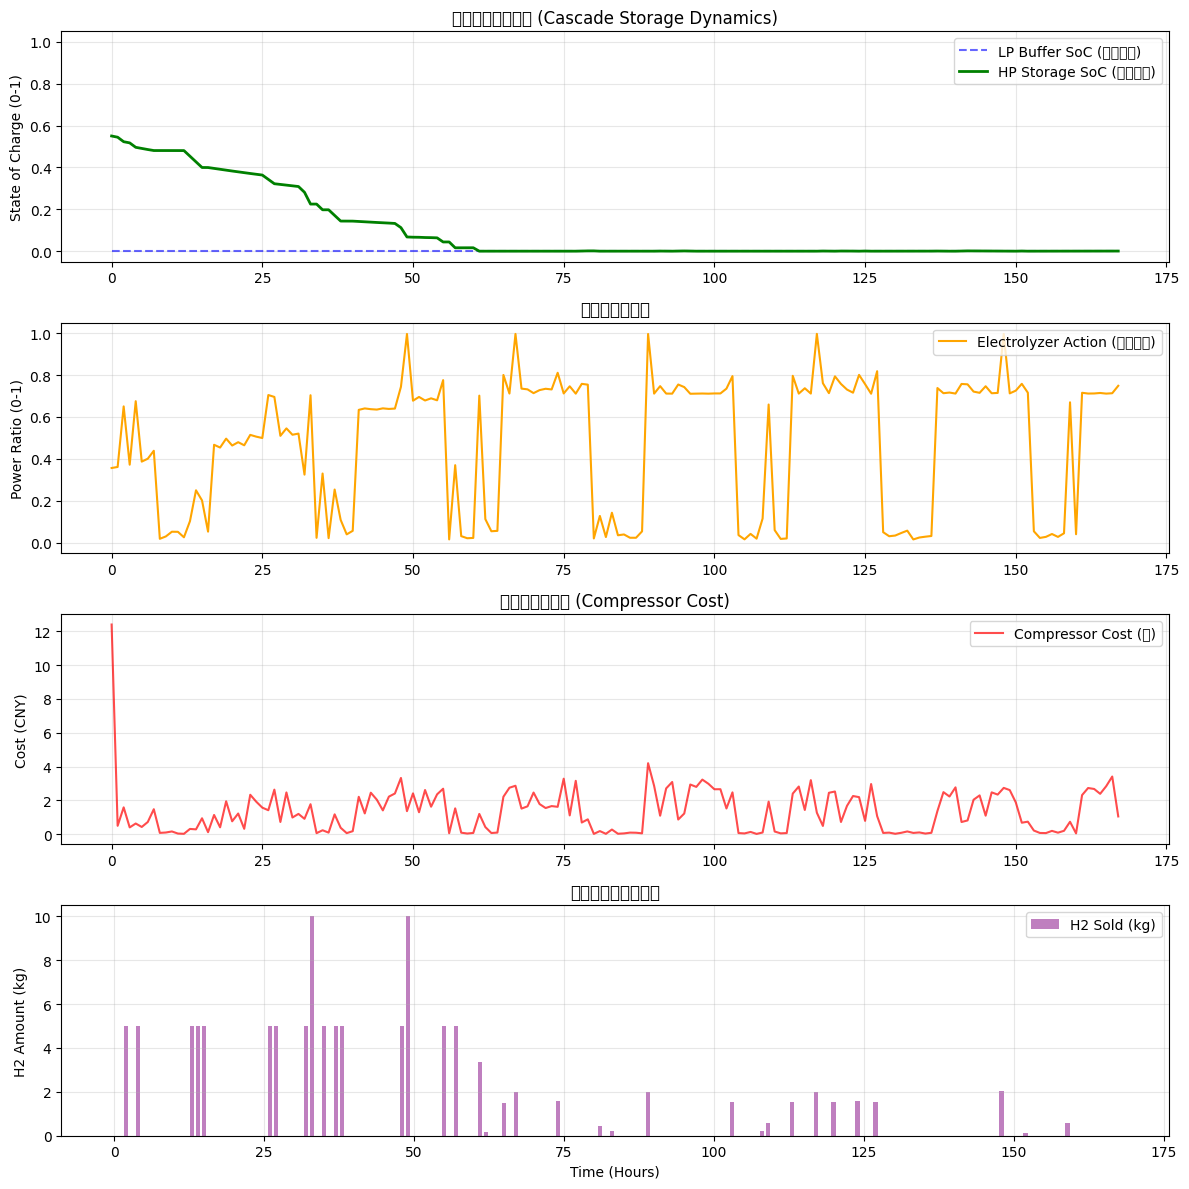

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# ==============================================================================
# Cell 7: 模型测试与可视化 (Visualization)
# ==============================================================================

# 1. 准备测试环境
# 确保 env 和 model 已经在前面的 Cell 中定义并训练好
print("正在重置环境进行测试...")
obs = env.reset()

# 用于存储轨迹数据的字典
trajectory = {
    'soc_lp': [],
    'soc_hp': [],
    'rewards': [],
    'action_ely': [],
    'comp_cost': [],
    'h2_sold': []
}

# 设定测试时长 (例如 24 * 7 = 168 小时，即一周)
test_steps = 168
print(f"开始可视化推演 (测试时长: {test_steps} 小时)...")

for i in range(test_steps):
    # 使用训练好的模型进行预测 (deterministic=True 表示使用确定性策略，去除随机探索)
    action, _states = model.predict(obs, deterministic=True)

    # 执行一步交互
    obs, reward, done, info = env.step(action)

    # 注意: 因为使用了 DummyVecEnv, info 是一个列表，我们需要取第一个环境的数据
    info_dict = info[0]

    # 记录关键数据
    trajectory['soc_lp'].append(info_dict['soc_lp'])
    trajectory['soc_hp'].append(info_dict['soc_hp'])
    trajectory['comp_cost'].append(info_dict['comp_cost'])
    trajectory['h2_sold'].append(info_dict['h2_sold'])

    # 记录动作 (VecEnv 返回的 action 也是数组)
    trajectory['action_ely'].append(action[0][0])
    trajectory['rewards'].append(reward[0])

    if done[0]:
        obs = env.reset()

# 2. 绘制结果图表
plt.figure(figsize=(12, 12))

# --- 子图 1: 级联存储 SoC 变化 (核心关注点) ---
plt.subplot(4, 1, 1)
plt.plot(trajectory['soc_lp'], label='LP Buffer SoC (低压缓冲)', color='blue', alpha=0.6, linestyle='--')
plt.plot(trajectory['soc_hp'], label='HP Storage SoC (高压主存)', color='green', linewidth=2)
plt.title('级联存储液位动态 (Cascade Storage Dynamics)')
plt.ylabel('State of Charge (0-1)')
plt.ylim(-0.05, 1.05)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# --- 子图 2: 电解槽功率策略 ---
plt.subplot(4, 1, 2)
plt.plot(trajectory['action_ely'], label='Electrolyzer Action (制氢比例)', color='orange')
plt.title('电解槽制氢策略')
plt.ylabel('Power Ratio (0-1)')
plt.ylim(-0.05, 1.05)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# --- 子图 3: 压缩机能耗成本 ---
plt.subplot(4, 1, 3)
plt.plot(trajectory['comp_cost'], label='Compressor Cost (元)', color='red', alpha=0.7)
plt.title('压缩机运行成本 (Compressor Cost)')
plt.ylabel('Cost (CNY)')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# --- 子图 4: 氢气销售量 ---
plt.subplot(4, 1, 4)
plt.bar(range(test_steps), trajectory['h2_sold'], label='H2 Sold (kg)', color='purple', alpha=0.5)
plt.title('氢气满足与销售情况')
plt.xlabel('Time (Hours)')
plt.ylabel('H2 Amount (kg)')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
import os

commit_message = "Update: Implemented Cascade Storage (LP+HP+Compressor) logic"

print("\n>>> 正在检查文件变更...")
!git status

print("\n>>> 添加所有变更文件...")
!git add .

print(f"\n>>> 提交变更: {commit_message}")
!git commit -m "$commit_message"

print("\n>>> 推送到 GitHub...")
# 注意：只要之前配置了 Token，这里应该能直接推
push_result = os.system("git push origin main")

if push_result == 0:
    print("\n✅ 推送成功！")
else:
    print("\n❌ 推送失败。请检查 Token 或网络。")


>>> 正在检查文件变更...
On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	modified:   Electrolyzer+Storage+FuelCell+Compressor/SAC.ipynb
	new file:   Electrolyzer+Storage+FuelCell+Compressor/SAC_Cascade.ipynb
	new file:   sac_cascade_storage.zip

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   Electrolyzer+Storage+FuelCell+Compressor/SAC_Cascade.ipynb


>>> 添加所有变更文件...

>>> 提交变更: Update: Implemented Cascade Storage (LP+HP+Compressor) logic
Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@292b9a9281c7.(none)')

>>> 推送到 